**Author: Chatard Laura**

**Modification: 5/09/2024**

# Models test

This notebook is the 2nd part of the project. 

We are looking for a model that can predict whether a client’s loan application should be accepted or not.

# Import

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_recall_curve, auc, confusion_matrix, make_scorer, fbeta_score, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.dummy import DummyClassifier

from scipy.optimize import linear_sum_assignment

import lightgbm as lgb

import shap

from imblearn.over_sampling import SMOTE

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# MLflow
#!pip install --upgrade mlflow
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

import time

import json

In [2]:
# Import data
data = pd.read_csv('data.csv')

In [3]:
# Versions
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn version: {LabelEncoder.__module__.split('.')[0]} {LabelEncoder.__module__.split('.')[1]}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"MLflow version: {mlflow.__version__}")

NumPy version: 1.24.3
Pandas version: 1.5.3
Scikit-learn version: sklearn preprocessing
Matplotlib version: 3.9.0
Seaborn version: 0.13.2
MLflow version: 2.16.0


# Fonctions

In [4]:
def conf_mat_transform(y_true, y_pred, class_labels, ax):
    """
    Transforms predicted labels to match true categories 
    by maximizing values on the diagonal of the confusion matrix.

    Args:
    - y_true: True labels
    - y_pred: Predicted labels
    - class_labels: Labels for display
    - ax: Matplotlib axis for plotting

    Returns:
    - y_pred_transform: Transformed predicted labels to match true categories
    - df_cm: DataFrame of the transformed confusion matrix for display
    """
    # Compute the confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    
    # Create the cost matrix to find the best match
    cost_matrix = -conf_mat  # Maximize the diagonal by minimizing the cost
    
    # Find the best permutation of columns to maximize diagonal values
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Reorder the columns of the confusion matrix based on the best permutation
    conf_mat_transformed = conf_mat[:, col_ind]
    
    # Create a mapping between clusters and true categories
    cluster_to_category = {i: col_ind[i] for i in range(len(col_ind))}
    
    # Transform predicted labels to match true categories
    y_pred_transform = np.array([cluster_to_category[cluster] for cluster in y_pred])
    
    # Create a DataFrame for better visualization
    df_cm = pd.DataFrame(conf_mat_transformed, index=class_labels, columns=class_labels)
    
    # Plot the confusion matrix
    sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d', ax=ax)
    ax.set_xlabel('Predictions')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')

    return y_pred_transform, df_cm

# MLflow tracking

First, let's begin by discovering the universe of MLflow tracking. 
Here is the [documentation](https://mlflow.org/docs/latest/tracking.html) for the terms used by MLflow.

## Preprocessing

In [5]:
# Create a client MLflow
client = MlflowClient()

# List of all client
experiments = client.search_experiments()

# Print information
for experiment in experiments:
    print(f"ID: {experiment.experiment_id}, Name: {experiment.name}")

ID: 471647679769818948, Name: P7_exp_LightGBM
ID: 160787238110460711, Name: P7_exp_dummy_classifier
ID: 150774441229989355, Name: P7_exp_random_forest
ID: 228532471274446842, Name: P7_exp_linear_reg
ID: 0, Name: Default


We are working with 50% of datasets; without this parameter, the models don’t work.

In [6]:
data_sample = data.sample(frac=0.5)
data_sample.head()

,Unnamed: 0,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
29090,208706,341896,0,0,0,1,0,90000.0,206280.0,10161.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6987,68580,179538,0,0,0,0,0,126000.0,900000.0,26446.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77.0
16914,33149,138408,0,0,0,0,2,135000.0,255429.0,30442.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
19199,99735,215784,0,1,0,0,0,85500.0,203760.0,19980.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4607,257104,397527,0,0,0,0,0,360000.0,819792.0,41985.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Define the data
X = data_sample.drop(columns=['TARGET'])
y = data_sample['TARGET']

# Store feature names before transformation
feature_names = X.columns.tolist()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Handle missing values: Impute missing values with the median and normalize the data
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

We use the fact that false negatives and false positives have different costs to refine the model.

In [8]:
# Custom weighted score function to penalize false positives and false negatives differently
C_FN = 10  # Cost of a false negative
C_FP = 1   # Cost of a false positive

def weighted_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (C_FN * fn + C_FP * fp) / len(y_true)

# y_train contains the labels of your training data
unique_classes, class_counts = np.unique(y_train, return_counts=True)

# Calculate the frequency of each class
class_frequencies = dict(zip(unique_classes, class_counts))

# Compute class weights based on class frequency
total_instances = len(y_train)
weight_0 = (total_instances / (2 * class_frequencies.get(0, 1))) * C_FN
weight_1 = (total_instances / (2 * class_frequencies.get(1, 1))) * C_FP

class_weights = {0: weight_0, 1: weight_1}

There is another approach to dealing with imbalanced data. We are testing [SMOTE](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/), which oversamples the minority class.

In [9]:
# Test SMOTE for Class Imbalance

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

## Choose metrics

The high accuracy may be due to the dataset being imbalanced. This [Kaggle](https://www.kaggle.com/code/marcinrutecki/best-techniques-and-metrics-for-imbalanced-dataset/notebook) resource helped me determine which metrics we should use.

![Metrics](info_metrics.png)

In this case, we know the cost of a false negative is ten times higher than the cost of a false positive.
For this project, the goal is to make predictions so that the bank can make the most advantageous decisions.

Other metrics :
- Time
- weighted score
- [Beta score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html)

## Test models

### Linear Regression

In [10]:
# ID 
P7_exp_linear_reg = "228532471274446842" 

2024/09/06 13:11:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Accuracy: 0.6511703511053316
Precision-Recall AUC: 0.18228839562108923
Weighted Score: 0.6589726918075423
Beta Score: 0.5292129798998415
Prediction time: 0.0014688968658447266 seconds


<Figure size 640x480 with 0 Axes>

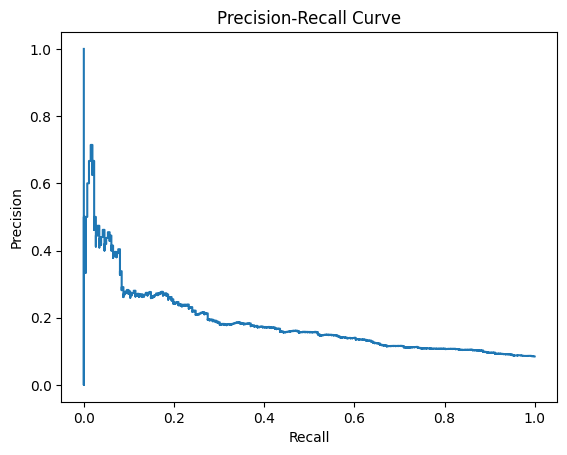

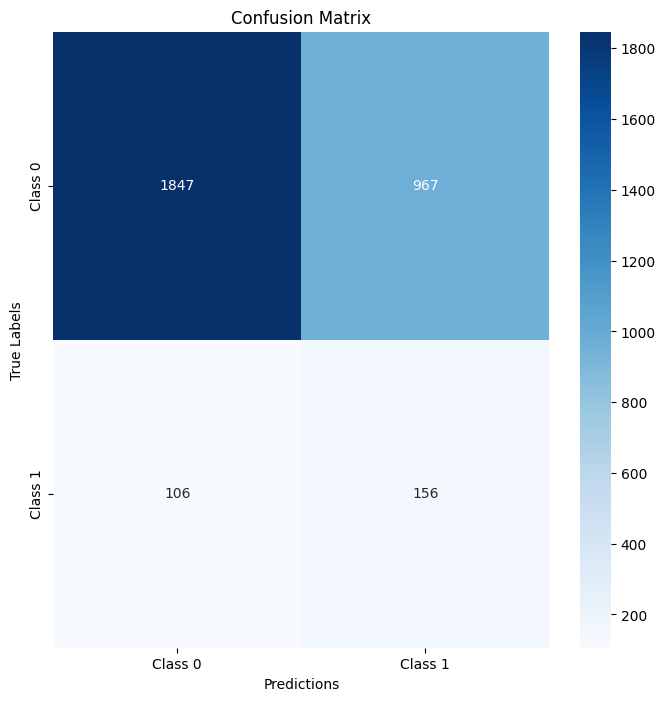

In [11]:
# Define the model and hyperparameters
C_value = 0.0001

# Start an MLflow run
with mlflow.start_run(run_name="LinearRegression_test_SMOTE", experiment_id=P7_exp_linear_reg):
    start_time = time.time()
    
    # Create and train the model
    log_reg = LogisticRegression(C=C_value, random_state=42)
    log_reg.fit(X_train_res, y_train_res)

    # Log training time
    training_time = time.time() - start_time
    mlflow.log_metric("training_time", training_time)

    # Make predictions
    start_time = time.time()
    log_reg_pred_proba = log_reg.predict_proba(X_test)[:, 1]
    threshold = 0.5
    predictions = (log_reg_pred_proba > threshold).astype(int)
    prediction_time = time.time() - start_time
    mlflow.log_metric("prediction_time", prediction_time)

    # Calculate metrics
    accuracy = accuracy_score(y_test, predictions)
    precision, recall, _ = precision_recall_curve(y_test, log_reg_pred_proba)
    pr_auc = auc(recall, precision)
    weighted_score_val = weighted_score(y_test, predictions)
    beta_score = fbeta_score(y_test, predictions, average='macro', beta=2)

    # Log parameters and metrics in MLflow
    mlflow.log_param("C", C_value)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision_recall_auc", pr_auc)
    mlflow.log_metric("weighted_score", weighted_score_val)
    mlflow.log_metric("beta_score", beta_score)

    # Save the precision-recall curve as an artifact
    plt.figure()
    PrecisionRecallDisplay(precision, recall).plot()
    plt.title("Precision-Recall Curve")
    plt.savefig("precision_recall_curve.png")
    mlflow.log_artifact("precision_recall_curve.png")

    # Save the confusion matrix as an artifact using the custom function
    fig, ax = plt.subplots(figsize=(8, 8))
    y_pred_transform, df_cm = conf_mat_transform(y_test, predictions, class_labels=['Class 0', 'Class 1'], ax=ax)
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Log the model in MLflow
    mlflow.sklearn.log_model(log_reg, "logistic_regression_model")

    # Save the metrics as a JSON file
    metrics = {
        "accuracy": accuracy,
        "precision_recall_auc": pr_auc,
        "weighted_score": weighted_score_val,
        "beta_score": beta_score,
        "training_time": training_time,
        "prediction_time": prediction_time
    }

    with open("metrics.json", "w") as f:
        json.dump(metrics, f)
    mlflow.log_artifact("metrics.json")

    # Print the results
    print(f"Accuracy: {accuracy}")
    print(f"Precision-Recall AUC: {pr_auc}")
    print(f"Weighted Score: {weighted_score_val}")
    print(f"Beta Score: {beta_score}")
    print(f"Prediction time: {prediction_time} seconds")

### DummyClassifier

In [12]:
# Create a new experiment and get its ID
#experiment_id = mlflow.create_experiment('P7_exp_dummy_classifier')

# ID
P7_exp_dummy_classifier = "160787238110460711"

2024/09/06 13:11:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Accuracy: 0.5032509752925878
Precision-Recall AUC: 0.3121430596437543
Weighted Score: 0.88296488946684
Beta Score: 0.40308599031072867
Prediction time: 0.0002739429473876953 seconds


<Figure size 640x480 with 0 Axes>

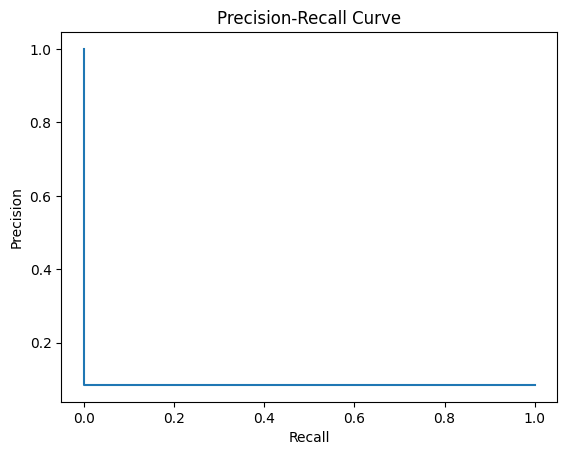

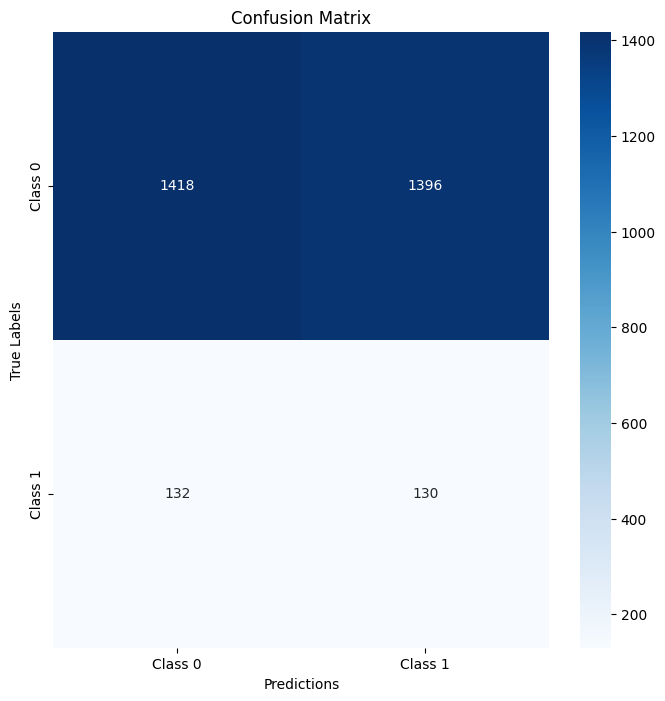

In [13]:
dummy_classifier = DummyClassifier(strategy='stratified', random_state=42)

# Define a pipeline with DummyClassifier
pipeline = Pipeline([
    ('classifier', dummy_classifier)
])


# Run the experiment with MLflow
with mlflow.start_run(run_name="DummyClassifier_experiment_SMOTE", experiment_id=P7_exp_dummy_classifier):
    start_time = time.time()

    # Fit the DummyClassifier
    pipeline.fit(X_train_res, y_train_res)

    # Log training time
    training_time = time.time() - start_time
    mlflow.log_metric("training_time", training_time)

    # Evaluate the DummyClassifier on the test set
    start_time = time.time()
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    threshold = 0.3
    y_pred = (y_pred_proba > threshold).astype(int)
    prediction_time = time.time() - start_time
    mlflow.log_metric("prediction_time", prediction_time)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    weighted_score_val = weighted_score(y_test, y_pred)
    beta_score = fbeta_score(y_test, y_pred, average='macro', beta=2)

    # Log parameters and metrics in MLflow
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision_recall_auc", pr_auc)
    mlflow.log_metric("weighted_score", weighted_score_val)
    mlflow.log_metric("beta_score", beta_score)

    # Save the precision-recall curve as an artifact
    plt.figure()
    PrecisionRecallDisplay(precision, recall).plot()
    plt.title("Precision-Recall Curve")
    plt.savefig("precision_recall_curve.png")
    mlflow.log_artifact("precision_recall_curve.png")

    # Save the confusion matrix as an artifact using the custom function
    fig, ax = plt.subplots(figsize=(8, 8))
    y_pred_transform, df_cm = conf_mat_transform(y_test, y_pred, class_labels=['Class 0', 'Class 1'], ax=ax)
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Log the model in MLflow
    mlflow.sklearn.log_model(pipeline, "dummy_model")

    # Save the metrics as a JSON file
    metrics = {
        "accuracy": accuracy,
        "precision_recall_auc": pr_auc,
        "weighted_score": weighted_score_val,
        "beta_score": beta_score,
        "training_time": training_time,
        "prediction_time": prediction_time
    }

    with open("metrics.json", "w") as f:
        json.dump(metrics, f)
    mlflow.log_artifact("metrics.json")

    # Print the results
    print(f"Accuracy: {accuracy}")
    print(f"Precision-Recall AUC: {pr_auc}")
    print(f"Weighted Score: {weighted_score_val}")
    print(f"Beta Score: {beta_score}")
    print(f"Prediction time: {prediction_time} seconds")

## Models

### RandomForest

In [14]:
# Create a new experiment and get its ID
#experiment_id = mlflow.create_experiment('P7_exp_random_forest')

2024/09/06 13:22:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best model parameters: {'classifier__bootstrap': False, 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Accuracy: 0.83777633289987
Precision-Recall AUC: 0.182300516741055
Weighted Score: 0.7005851755526658
Beta Score: 0.5835255765691487
Prediction time: 0.09056472778320312 seconds


<Figure size 640x480 with 0 Axes>

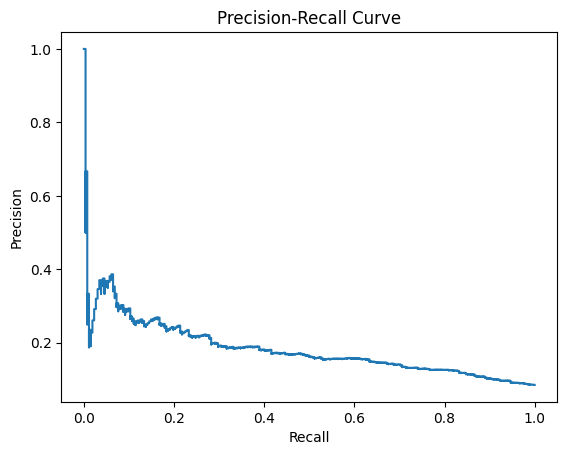

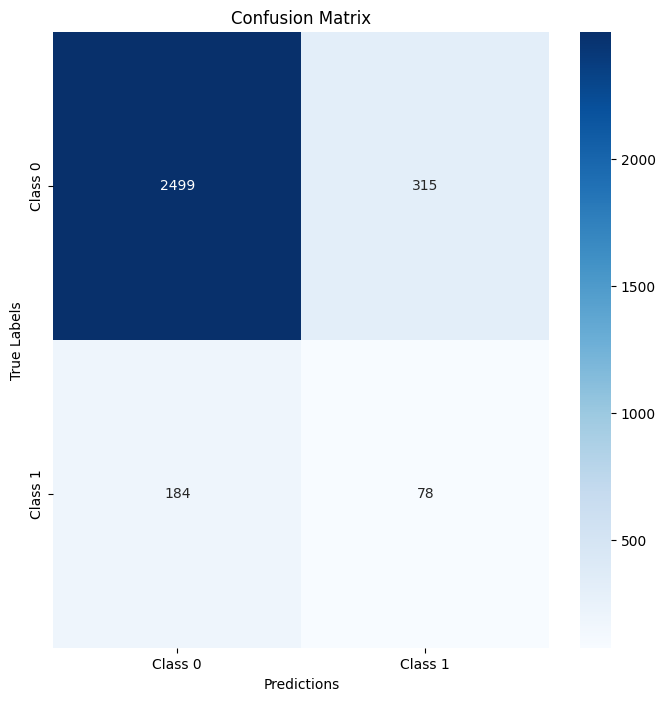

In [15]:
# Execute the experiment with MLflow
with mlflow.start_run(run_name="RandomForest_SMOTE", experiment_id=150774441229989355):
    start_time = time.time()
    
    # Define a pipeline and grid search
    pipeline = Pipeline([
        ('classifier', RandomForestClassifier(class_weight=class_weights, random_state=42))
    ])

    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 20],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 2],
        'classifier__bootstrap': [True, False]
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=0)

    # Run GridSearchCV to find the best hyperparameters
    grid_search.fit(X_train_res, y_train_res)

    # Log training time
    training_time = time.time() - start_time
    mlflow.log_metric("training_time", training_time)

    # Get the best model from the grid search
    best_model = grid_search.best_estimator_

    # Evaluate the best model on the test set
    start_time = time.time()
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    threshold = 0.3
    y_pred = (y_pred_proba > threshold).astype(int)
    prediction_time = time.time() - start_time
    mlflow.log_metric("prediction_time", prediction_time)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    weighted_score_val = weighted_score(y_test, y_pred)
    beta_score = fbeta_score(y_test, y_pred, average='macro', beta=2)

    # Log parameters and metrics in MLflow
    mlflow.log_param("best_n_estimators", grid_search.best_params_['classifier__n_estimators'])
    mlflow.log_param("best_max_depth", grid_search.best_params_['classifier__max_depth'])
    mlflow.log_param("best_min_samples_split", grid_search.best_params_['classifier__min_samples_split'])
    mlflow.log_param("best_min_samples_leaf", grid_search.best_params_['classifier__min_samples_leaf'])
    mlflow.log_param("best_bootstrap", grid_search.best_params_['classifier__bootstrap'])

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision_recall_auc", pr_auc)
    mlflow.log_metric("weighted_score", weighted_score_val)
    mlflow.log_metric("beta_score", beta_score)

    # Save the precision-recall curve as an artifact
    plt.figure()
    PrecisionRecallDisplay(precision, recall).plot()
    plt.title("Precision-Recall Curve")
    plt.savefig("precision_recall_curve.png")
    mlflow.log_artifact("precision_recall_curve.png")

    # Save the confusion matrix as an artifact using the custom function
    fig, ax = plt.subplots(figsize=(8, 8))
    y_pred_transform, df_cm = conf_mat_transform(y_test, y_pred, class_labels=['Class 0', 'Class 1'], ax=ax)
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Log the best model in MLflow
    mlflow.sklearn.log_model(best_model, "best_model")

    # Save the best parameters as an artifact
    with open("best_model_params.txt", "w") as f:
        f.write(str(grid_search.best_params_))
    mlflow.log_artifact("best_model_params.txt")

    # Save the metrics as a JSON file
    metrics = {
        "accuracy": accuracy,
        "precision_recall_auc": pr_auc,
        "weighted_score": weighted_score_val,
        "beta_score": beta_score,
        "training_time": training_time,
        "prediction_time": prediction_time
    }

    with open("metrics.json", "w") as f:
        json.dump(metrics, f)
    mlflow.log_artifact("metrics.json")

    # Print the results
    print(f"Best model parameters: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision-Recall AUC: {pr_auc}")
    print(f"Weighted Score: {weighted_score_val}")
    print(f"Beta Score: {beta_score}")
    print(f"Prediction time: {prediction_time} seconds")

### LightBoosting

After testing Random Forest, we will test the LightBoosting model. We chose it for its speed, which is an important business characteristic.

In [16]:
# Create a new experiment and get its ID
#experiment_id = mlflow.create_experiment('P7_exp_LightGBM')

# ID
P7_exp_LightGBM = "471647679769818948"

#Calculate scale_pos_weight
#Assuming y_train is a pandas Series or can be converted to one
y_train_series = pd.Series(y_train)

#Number of negative samples (class label 0à
num_negative_samples = (y_train_series == 0).sum()

#Number of positive samples
num_positive_samples = (y_train_series == 1).sum()
scale_pos_weight = num_negative_samples / num_positive_samples

#Define the LightGBM model with scale_pos_weight
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight)

In [17]:
# Define the LightGBM model
lgb_model = lgb.LGBMClassifier(class_weight=class_weights, objective='binary', metric='binary_logloss',
                               random_state=42, verbose=0)

# Define the pipeline and grid search
pipeline = Pipeline([
    ('classifier', lgb_model)
])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__num_leaves': [31, 63]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=0)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


2024/09/06 13:29:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best model parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__n_estimators': 200, 'classifier__num_leaves': 63}
Accuracy: 0.9161248374512354
Precision-Recall AUC: 0.23813798525474467
Weighted Score: 0.8211963589076723
Beta Score: 0.5138566764774467
Prediction time: 0.019020795822143555 seconds


<Figure size 640x480 with 0 Axes>

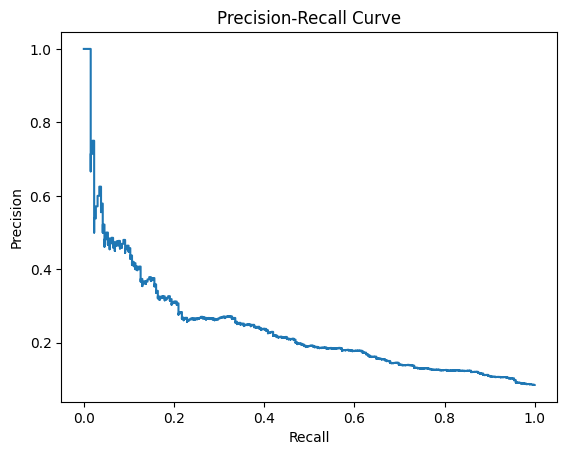

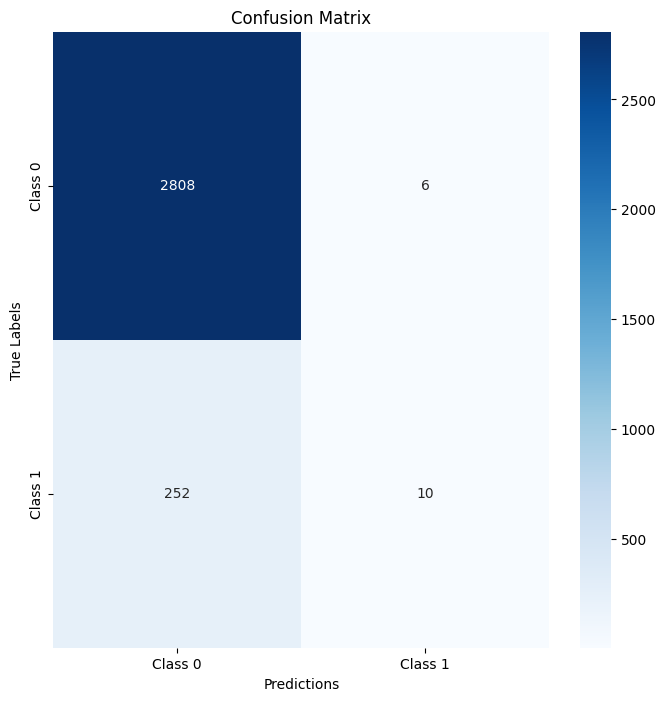

In [18]:
# Execute the experiment with MLflow
with mlflow.start_run(run_name="LightGBM_SMOTE", experiment_id=P7_exp_LightGBM):
    start_time = time.time()

    # Run GridSearchCV to find the best hyperparameters
    grid_search.fit(X_train_res, y_train_res)

    # Log training time
    training_time = time.time() - start_time
    mlflow.log_metric("training_time", training_time)

    # Get the best model from the grid search
    best_model = grid_search.best_estimator_

    # Evaluate the best model on the test set
    start_time = time.time()
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    threshold = 0.5
    y_pred = (y_pred_proba > threshold).astype(int)
    prediction_time = time.time() - start_time
    mlflow.log_metric("prediction_time", prediction_time)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    weighted_score_val = weighted_score(y_test, y_pred)
    beta_score = fbeta_score(y_test, y_pred, average='macro', beta=2)

    # Log parameters and metrics in MLflow
    mlflow.log_param("best_n_estimators", grid_search.best_params_['classifier__n_estimators'])
    mlflow.log_param("best_max_depth", grid_search.best_params_['classifier__max_depth'])
    mlflow.log_param("best_learning_rate", grid_search.best_params_['classifier__learning_rate'])
    mlflow.log_param("best_num_leaves", grid_search.best_params_['classifier__num_leaves'])

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision_recall_auc", pr_auc)
    mlflow.log_metric("weighted_score", weighted_score_val)
    mlflow.log_metric("beta_score", beta_score)

    # Save the precision-recall curve as an artifact
    plt.figure()
    PrecisionRecallDisplay(precision, recall).plot()
    plt.title("Precision-Recall Curve")
    plt.savefig("precision_recall_curve.png")
    mlflow.log_artifact("precision_recall_curve.png")

    # Save the confusion matrix as an artifact using the custom function
    fig, ax = plt.subplots(figsize=(8, 8))
    y_pred_transform, df_cm = conf_mat_transform(y_test, y_pred, class_labels=['Class 0', 'Class 1'], ax=ax)
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Log the best model in MLflow
    mlflow.sklearn.log_model(best_model, "best_model")

    # Save the best parameters as an artifact
    with open("best_model_params.txt", "w") as f:
        f.write(str(grid_search.best_params_))
    mlflow.log_artifact("best_model_params.txt")

    # Save the metrics as a JSON file
    metrics = {
        "accuracy": accuracy,
        "precision_recall_auc": pr_auc,
        "weighted_score": weighted_score_val,
        "beta_score": beta_score,
        "training_time": training_time,
        "prediction_time": prediction_time
    }

    with open("metrics.json", "w") as f:
        json.dump(metrics, f)
    mlflow.log_artifact("metrics.json")

    # Print the results
    print(f"Best model parameters: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision-Recall AUC: {pr_auc}")
    print(f"Weighted Score: {weighted_score_val}")
    print(f"Beta Score: {beta_score}")
    print(f"Prediction time: {prediction_time} seconds")

# Features importance

In [19]:
# If you have a pipeline, extract the model
lgb_model = best_model.named_steps['classifier']

# Create a SHAP explainer using the raw data before transformation
explainer = shap.Explainer(lgb_model, X_train)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

# Summary plot (global view of feature importances)
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

 99%|===================| 3058/3076 [00:31<00:00]        

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was -7.585795, while the model output was -7.438525. If this difference is acceptable you can set check_additivity=False to disable this check.

**COMMENTAIRE**

In [ ]:
# Select a specific client's data 
client_index = 0  # Change this to target a specific client
client_data = X_test[client_index:client_index+1]

# Get SHAP values for this specific client
shap_values_client = explainer(client_data)

# Pass feature names directly to the SHAP values for visualization
shap_values_client.data = client_data  # Actual values for the client
shap_values_client.feature_names = feature_names  # Attach feature names

# Waterfall plot for a single client
shap.plots.waterfall(shap_values_client[0])

Now, we are wondering if the important features variation depending on the prediction.

In [ ]:
# Get the indices of the different cases
false_positives = (y_pred == 1) & (y_test == 0)
false_negatives = (y_pred == 0) & (y_test == 1)
true_positives = (y_pred == 1) & (y_test == 1)
true_negatives = (y_pred == 0) & (y_test == 0)

# Helper function to safely get the index
def get_first_index(case, case_name):
    if case.sum() > 0:  # Check if there are any instances of this case
        return np.where(case)[0][0]  # Return the first index where the condition is True
    else:
        print(f"No instances of {case_name} found.")
        return None

# Get the index for each case
fp_index = get_first_index(false_positives, "False Positive")
fn_index = get_first_index(false_negatives, "False Negative")
tp_index = get_first_index(true_positives, "True Positive")
tn_index = get_first_index(true_negatives, "True Negative")

In [ ]:
# List of client indices
client_indices = {
    'False Positive': fp_index,
    'False Negative': fn_index,
    'True Positive': tp_index,
    'True Negative': tn_index
}

# Loop over each category and plot the local feature importance using SHAP
for label, client_index in client_indices.items():
    print(f"Generating SHAP Waterfall plot for {label} client")

    # Select the client's data
    client_data = X_test[client_index:client_index+1]

    # Get SHAP values for this specific client
    shap_values_client = explainer(client_data)

    # Set the feature names
    shap_values_client.feature_names = feature_names

    # Waterfall plot for the specific client
    shap.plots.waterfall(shap_values_client[0])